In [ ]:
import pandas as pd
import numpy as np

# Load your CSV
df=pd.read_csv('/content/final_mixed_gene_dataset.csv')

#Convert to dataframe
df=pd.DataFrame(df)

# Preview
print(df.head())

print(df.shape)

# Load embeddings into dict: gene -> vector
def load_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            gene = parts[0]
            vector = np.array(parts[1:], dtype=float)
            embeddings[gene] = vector
    return embeddings

embeddings_path = 'gene2vec_dim_200_iter_9.txt'  # Replace if needed
gene_embeddings = load_embeddings(embeddings_path)
print(f"Loaded embeddings for {len(gene_embeddings)} genes")


                                             Gene(s) Protein change  \
0  GRB14|SCN1A|COBLL1|CSRNP3|GALNT3|SCN2A|SCN3A|S...            NaN   
1  ACR|ADM2|ALG12|ARSA|ATXN10|BRD1|CDPF1|CELSR1|C...    p.Pro929Pro   
2  ACR|ADM2|ALG12|ARSA|BRD1|CHKB|CIMAP1B|CPT1B|CR...    p.Ala868Ala   
3  GRAMD4|GTSE1|MAPK12|MAPK8IP2|KLHDC7B|LMF2|MAPK...        unknown   
4  ACR|ADM2|CPT1B|CRELD2|DENND6B|ALG12|ARSA|BRD1|...   p.Leu1389Pro   

              Condition(s) Canonical SPDI      Variant type  \
0            not specified            NaN  copy number loss   
1                      NaN            NaN               SNV   
2                      NaN            NaN               SNV   
3  Intellectual disability            NaN          Deletion   
4                      NaN            NaN               SNV   

  Molecular consequence Germline classification  
0                   NaN              Pathogenic  
1    synonymous_variant                  Benign  
2    synonymous_variant                  Ben

In [ ]:
def get_row_embedding(gene_str):
    genes = gene_str.split('|')
    vectors = [gene_embeddings.get(g, np.zeros(embedding_dim)) for g in genes]
    if vectors:
        return np.mean(vectors, axis=0)  # average embedding vector
    else:
        return np.zeros(embedding_dim)

embedding_dim = len(next(iter(gene_embeddings.values())))  # Add this line before calling get_row_embedding

emb_matrix = np.array([get_row_embedding(gene_str) for gene_str in df['Gene(s)']])


In [ ]:
import pandas as pd
import numpy as np

# emb_matrix shape: (num_rows, embedding_dim)
embedding_dim = emb_matrix.shape[1]

# Create a DataFrame with embedding columns
emb_df = pd.DataFrame(emb_matrix, columns=[f'emb_{i}' for i in range(embedding_dim)])

# Concatenate with original df
df = pd.concat([df.reset_index(drop=True), emb_df.reset_index(drop=True)], axis=1)

print(df.head())


                                             Gene(s) Protein change  \
0  GRB14|SCN1A|COBLL1|CSRNP3|GALNT3|SCN2A|SCN3A|S...            NaN   
1  ACR|ADM2|ALG12|ARSA|ATXN10|BRD1|CDPF1|CELSR1|C...    p.Pro929Pro   
2  ACR|ADM2|ALG12|ARSA|BRD1|CHKB|CIMAP1B|CPT1B|CR...    p.Ala868Ala   
3  GRAMD4|GTSE1|MAPK12|MAPK8IP2|KLHDC7B|LMF2|MAPK...        unknown   
4  ACR|ADM2|CPT1B|CRELD2|DENND6B|ALG12|ARSA|BRD1|...   p.Leu1389Pro   

              Condition(s) Canonical SPDI      Variant type  \
0            not specified            NaN  copy number loss   
1                      NaN            NaN               SNV   
2                      NaN            NaN               SNV   
3  Intellectual disability            NaN          Deletion   
4                      NaN            NaN               SNV   

  Molecular consequence Germline classification     emb_0     emb_1     emb_2  \
0                   NaN              Pathogenic -0.000091  0.031085  0.056866   
1    synonymous_variant         

Step 3: Encode Target Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Drop rows with missing target
df = df[df['Germline classification'].notnull()]

# Encode target labels
le = LabelEncoder()
df['target'] = le.fit_transform(df['Germline classification'])

print("Classes:", le.classes_)
print(df[['Germline classification', 'target']].head())


Classes: ['Benign' 'Benign/Likely benign' 'Likely benign' 'Likely pathogenic'
 'Pathogenic']
  Germline classification  target
0              Pathogenic       4
1                  Benign       0
2                  Benign       0
3              Pathogenic       4
4                  Benign       0


Step 4: Prepare Features and Labels for ML

In [ ]:
# Select embedding columns as features
feature_cols = [col for col in df.columns if col.startswith('emb_')]
X = df[feature_cols].values
y = df['target'].values

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


Feature matrix shape: (521, 200)
Labels shape: (521,)


In [ ]:
# Redefine feature columns
feature_cols = [col for col in df.columns if col.startswith('emb_')]
X = df[feature_cols].values
y = df['target'].values

# Check shape
print("X shape:", X.shape)
print("y shape:", y.shape)

# Proceed with train-test split


X shape: (521, 200)
y shape: (521,)


In [ ]:
# Step 1: Confirm embedding dimension
embedding_dim = len(next(iter(gene_embeddings.values())))  # should be 200

# Step 2: Generate embedding matrix for each row
emb_matrix = np.array([get_row_embedding(gene_str) for gene_str in df['Gene(s)']])

# Step 3: Make sure emb_matrix is valid
print("Embedding matrix shape:", emb_matrix.shape)  # should be (num_rows, 200)

# Step 4: Convert to DataFrame
emb_df = pd.DataFrame(emb_matrix, columns=[f'emb_{i}' for i in range(embedding_dim)])

# Step 5: Combine with original df
df = pd.concat([df.reset_index(drop=True), emb_df.reset_index(drop=True)], axis=1)

# Step 6: Recheck column names
print("Columns in df:", df.columns.tolist())


Embedding matrix shape: (521, 200)
Columns in df: ['Gene(s)', 'Protein change', 'Condition(s)', 'Canonical SPDI', 'Variant type', 'Molecular consequence', 'Germline classification', 'emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6', 'emb_7', 'emb_8', 'emb_9', 'emb_10', 'emb_11', 'emb_12', 'emb_13', 'emb_14', 'emb_15', 'emb_16', 'emb_17', 'emb_18', 'emb_19', 'emb_20', 'emb_21', 'emb_22', 'emb_23', 'emb_24', 'emb_25', 'emb_26', 'emb_27', 'emb_28', 'emb_29', 'emb_30', 'emb_31', 'emb_32', 'emb_33', 'emb_34', 'emb_35', 'emb_36', 'emb_37', 'emb_38', 'emb_39', 'emb_40', 'emb_41', 'emb_42', 'emb_43', 'emb_44', 'emb_45', 'emb_46', 'emb_47', 'emb_48', 'emb_49', 'emb_50', 'emb_51', 'emb_52', 'emb_53', 'emb_54', 'emb_55', 'emb_56', 'emb_57', 'emb_58', 'emb_59', 'emb_60', 'emb_61', 'emb_62', 'emb_63', 'emb_64', 'emb_65', 'emb_66', 'emb_67', 'emb_68', 'emb_69', 'emb_70', 'emb_71', 'emb_72', 'emb_73', 'emb_74', 'emb_75', 'emb_76', 'emb_77', 'emb_78', 'emb_79', 'emb_80', 'emb_81', 'emb_82'

In [ ]:
# Make sure target column is valid
df = df[df['Germline classification'].notnull()]
df['target'] = le.fit_transform(df['Germline classification'])

# Regenerate X, y
feature_cols = [col for col in df.columns if col.startswith('emb_')]
X = df[feature_cols].values
y = df['target'].values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (521, 800)
y shape: (521,)


Step 5: Train-Test Split & Model Training

Using Random Forest classifier as a solid baseline:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("📊 Classification Report:\n", classification_report(y_test, y_pred))


🔍 Accuracy: 0.9428571428571428
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        42
           2       0.50      0.50      0.50         4
           3       0.00      0.00      0.00         2
           4       0.97      1.00      0.98        57

    accuracy                           0.94       105
   macro avg       0.60      0.61      0.61       105
weighted avg       0.92      0.94      0.93       105



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")


Overall Accuracy: 0.9429


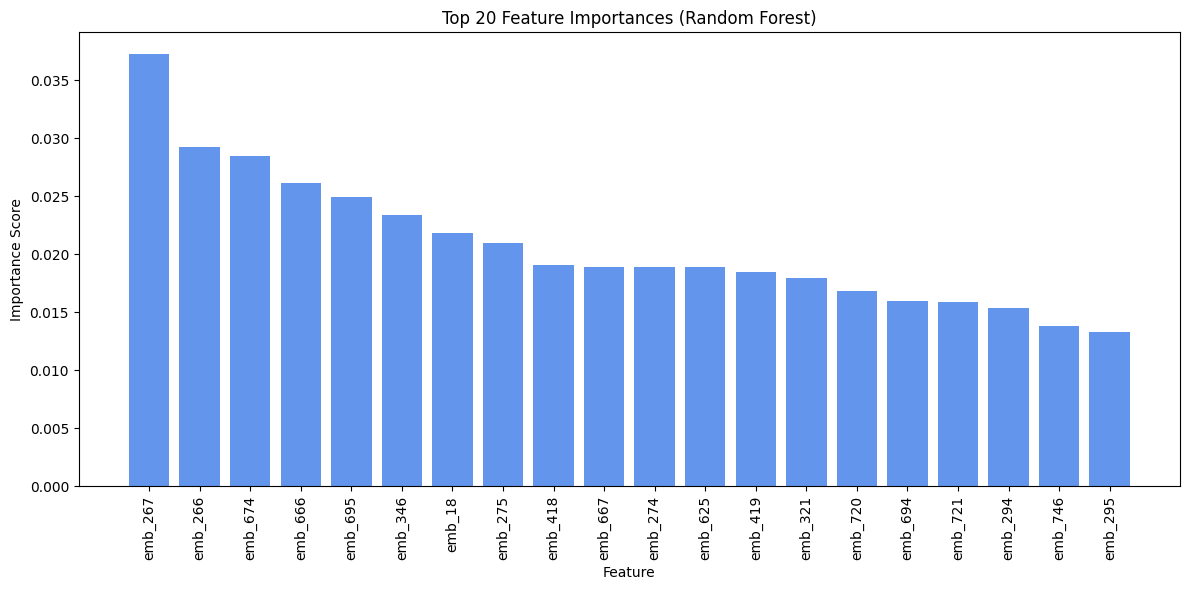

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Use the correct trained model variable
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.bar(range(20), importances[indices][:20], align='center', color='#6495ED')  # Light blue color
plt.xticks(range(20), [f'emb_{i}' for i in indices[:20]], rotation=90)
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


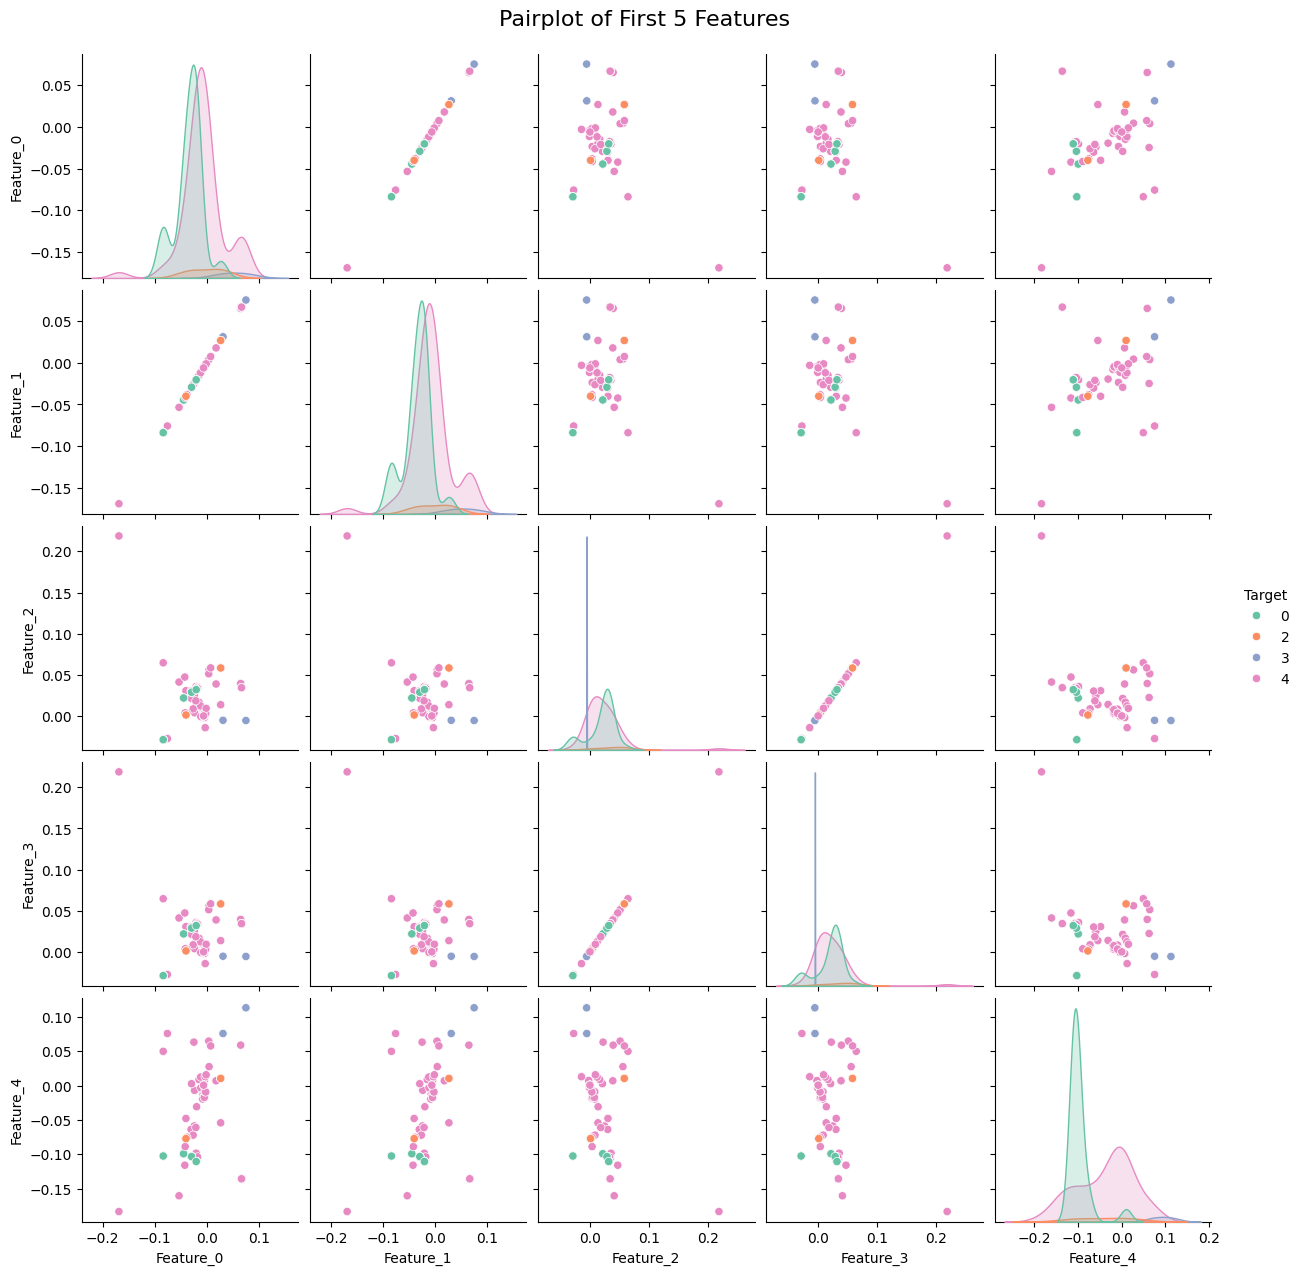

In [ ]:
import seaborn as sns
import pandas as pd

# Assume X_test is a DataFrame or convert to DataFrame with feature names
df = pd.DataFrame(X_test, columns=[f'Feature_{i}' for i in range(X_test.shape[1])])
df['Target'] = y_test

sns.pairplot(df.iloc[:, :5].assign(Target=df['Target'].astype('category')), hue='Target', palette='Set2')
plt.suptitle('Pairplot of First 5 Features', y=1.02, fontsize=16)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



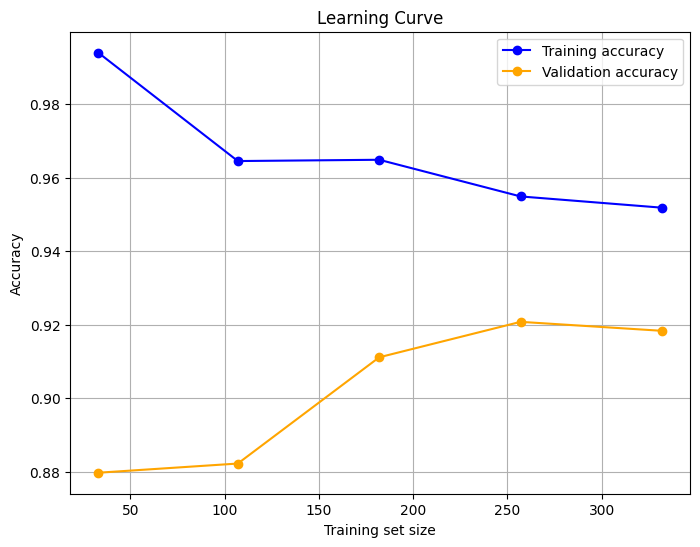

In [ ]:
import matplotlib.pyplot as plt

y_pred = clf.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.hlines(0, min(y_pred), max(y_pred), colors='r', linestyles='dashed')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residual Plot')
plt.show()
